# Readme

This notebook accompanies preprint _Efficient variational synthesis of quantum circuits with coherent multi-start optimization_ https://arxiv.org/abs/2205.01121. It is mostly intended to reproduce plots and circtuis from the paper and no effort was made to make it self-contained. For motivation behind the algorithm see the original paper. For instructions on how to use `CPFlow` package see the the tutorial notebook instead https://github.com/idnm/cpflow.

Here results are simply loaded from datafiles external to this notebook. However, most of the results can be easily reproduced (provided enough computational resources). In the process of generating decomposition during static/adaptive synthesis, additional information is attached to each decomposition object by CPFlow, that allows to reproduce the whole synthesis process from a scratch. This is exemplified in the section decribing the 3q Toffoli gate on connected topology.

# Imports and auxiliary functions

## Colab setup

In [1]:
try:
   import cpflow
except ImportError:
  !pip install cpflow

!git clone https://github.com/idnm/cpflow
!cp -r /content/cpflow/paper/results /content
!cp -r /content/cpflow/paper/benchmark_circuits /content
!mkdir figures

     |████████████████████████████████| 1.6 MB 21.6 MB/s 
     |████████████████████████████████| 136 kB 78.6 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 162 kB 68.2 MB/s 
     |████████████████████████████████| 199 kB 61.7 MB/s 
     |████████████████████████████████| 6.5 MB 62.2 MB/s 
     |████████████████████████████████| 18.0 MB 56.7 MB/s 
     |████████████████████████████████| 240 kB 58.5 MB/s 
     |████████████████████████████████| 200 kB 83.3 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 112 kB 68.1 MB/s 
     |████████████████████████████████| 1.6 MB 57.9 MB/s 
     |████████████████████████████████| 38.1 MB 489 kB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 943 kB 62.5 MB/s 
     |████████████████████████████████| 37.5 MB 1.1 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 
     |███████████████

## Other imports

In [12]:
from dataclasses import dataclass

from cpflow import *
from cpflow.topology import *
from cpflow.trigonometric_utils import random_angles, bracket_angle
from cpflow.matrix_utils import theoretical_lower_bound, cost_HST, disc_modulo_diagonal
from cpflow.main import RegularizationOptions
from cpflow.penalty import make_regularization_function
from cpflow.gates import u_toff3, u_toff4, u_toff5
from cpflow.trigonometric_utils import bracket_angle
from cpflow.exact_decompositions import remove_zero_rgates, reduce_angles, rationalize_all_rgates

from jax import vmap
from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import *
from qiskit.quantum_info import OneQubitEulerDecomposer, random_clifford, Operator
from qiskit.extensions import UnitaryGate

from scipy.stats import unitary_group
from fractions import Fraction
from pandas import DataFrame
import numpy as np

import pickle
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

def get_placements(circuit):
    placemets = []
    for gate, qargs, cargs in circuit.data:
        if gate.name == 'cz':
            i0 = qargs[0]._index
            i1 = qargs[1]._index
            placemets.append([i0, i1])
    return placemets

def mean_and_std(results):
    mean_list = []
    std_list = []
    for i in range(len(results[0])):
        sr_list = jnp.array([res[i]['success_ratio'] for res in results])
        mean_list.append(jnp.mean(sr_list))
        std_list.append(jnp.std(sr_list))
    
    return mean_list, std_list        

# Variational synthesis and its challanges

## Empirical success ratio: definition and example

Here the template depicted in Fig.4 in the paper. 

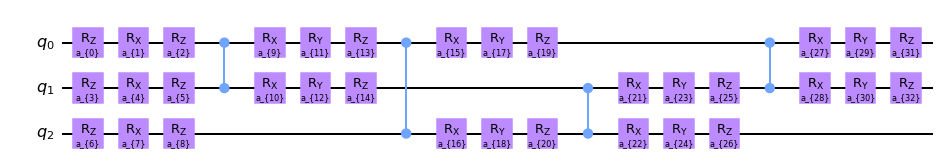

In [3]:
anz = Ansatz(3, 'cz', fill_layers(connected_layer(3), 4))
anz.circuit().draw(output='mpl')

Here is a particular random instance of that template.

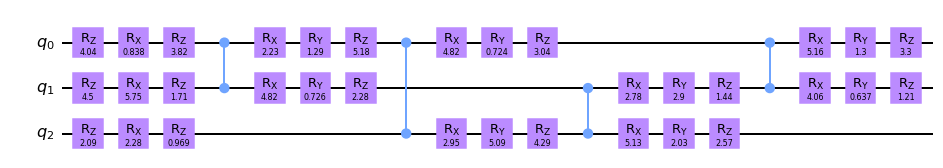

In [4]:
target_angles = random_angles(anz.num_angles)
target_circuit = anz.circuit(target_angles)
target_unitary = anz.unitary(target_angles)
target_circuit.draw(output='mpl')

Success Ratio of our default optimization procedure can be computed as follows.

In [5]:
results = anz.learn(
    target_unitary, 
    method='adam',
    learning_rate=0.1,
    num_iterations=5000,
    num_repeats=100)

loss_thredhold=1e-4

success_record = [jnp.min(r['loss'])<loss_thredhold for r in results]
sr = sum(success_record)/len(success_record)
print(f'Success Ratio is {sr}')

Success Ratio is 0.3100000023841858


## 3q chart

Here we load precomputed results for the 3q templates and reproduce left panel of Fig.3.

Mean Success Ration at 6 gates: self 0.11240001022815704, unitary 0.06379999965429306
Mean Success Ration at 8 gates: self 0.01810000091791153, unitary 0.011300000362098217


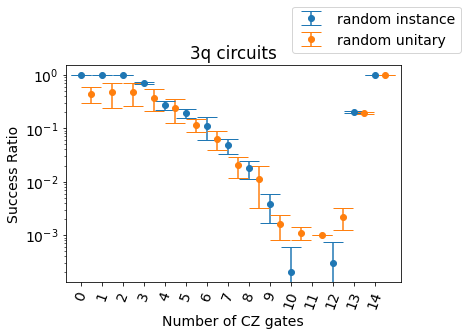

In [6]:
# Load results for 10 random instances.
results_self = []
for i in range(10):
    with open(f'results/local_minimums/3q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))

# Load results for 10 random unitaries.
results_unitary = []
for i in range(10):
    with open(f'results/local_minimums/3q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        

# Compute mean and standard deviation at each gate count        
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)

# Rememeber mean values of 6 and 8 gates. These are mentioned in Sec. V A in comparison with succes rates for the 3q Toffoli gate.
print(f'Mean Success Ration at 6 gates: self {mean_list_self[6]}, unitary {mean_list_unitary[6]}')
print(f'Mean Success Ration at 8 gates: self {mean_list_self[8]}, unitary {mean_list_unitary[8]}')


# Do the plotting.
plt.errorbar(range(len(mean_list_self)), mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random instance')
plt.errorbar(jnp.arange(len(mean_list_unitary))+0.5, mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')

plt.legend(bbox_to_anchor=(1.2, 1.3))

plt.yscale('log')
plt.xticks(range(len(mean_list_self)), rotation=70)
plt.ylabel('Success Ratio')
plt.xlabel('Number of CZ gates')
plt.title('3q circuits')
plt.savefig('figures/3q_success_chart', dpi=1000, bbox_inches='tight')

## 4q chart

Here we simply repeat what we did for the 3q chart.

Mean Success Ratio at 14 gates: self 0.0, unitary 0.0010999999940395355
Mean Success Ratio at 18 gates: self 0.0, unitary 0.0021000001579523087


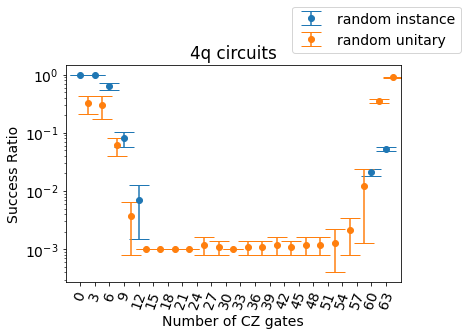

In [3]:
results_self = []
for i in range(10):
    with open(f'results/local_minimums/4q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))
        
results_unitary = []
for i in range(10):
    with open(f'results/local_minimums/4q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        
        
        
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)

print(f'Mean Success Ratio at 14 gates: self {mean_list_self[14]}, unitary {mean_list_unitary[14]}')
print(f'Mean Success Ratio at 18 gates: self {mean_list_self[18]}, unitary {mean_list_unitary[18]}')

xticks = jnp.arange(theoretical_lower_bound(4)+3)[::3]
plt.errorbar(xticks, mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random instance')
plt.errorbar(xticks+1.5, mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')
plt.legend(bbox_to_anchor=(1.2, 1.3))

plt.xlim([-3, 66])
plt.yscale('log')
plt.xticks(xticks, rotation=70)
plt.ylabel('Success Ratio')
plt.xlabel('Number of CZ gates')
plt.title('4q circuits')
plt.savefig('figures/4q_success_chart', dpi=1000, bbox_inches='tight')        

## Distribution of local minimums

In [103]:
def critical_distribution(E, p, m):
    return np.exp(-m*E/2)*(E**(m-p/2))*((1-E)**p)
def normalized_critical_distribution(E, p, m):
    values = critical_distribution(E, p, m)
    norm = values.sum()/len(values)*(E[-1]-E[0])
    return values/norm

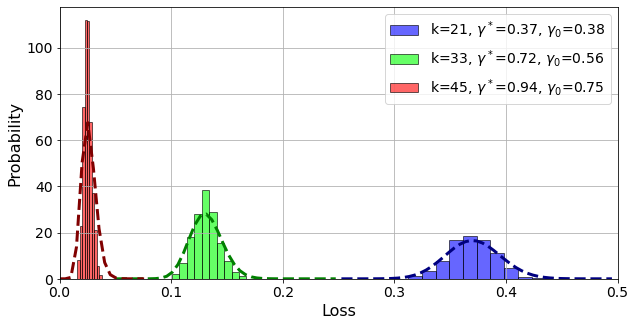

In [222]:
results0 = results_self[0]
res21 = results0[7]
res33 = results0[11]
res45 = results0[15]

gamma21 = (4*3+21*4)/256
gamma33 = (4*3+33*4)/256
gamma45 = (4*3+45*4)/256

plt.figure(figsize=(10, 5))

E = np.linspace(0, 0.5, 100)
E21 = E[(E>0.25)&(E<0.5)]
plt.plot(E21, normalized_critical_distribution(E21, 0.375*512, 256), color=(0, 0, 0.5), linewidth=3, linestyle='--')
E33 = E[(E>0.05)&(E<0.25)]
plt.plot(E33, normalized_critical_distribution(E33, 0.72*512, 256), color=(0, 0.5, 0), linewidth=3, linestyle='--')
E45 = E[(E>=0)&(E<0.08)]
plt.plot(E45, normalized_critical_distribution(E45, 0.94*512, 256), color=(0.5, 0, 0), linewidth=3, linestyle='--')
plt.xlim(0, 0.05)

plt.hist(np.array(res21['losses']), density=True, color=(0, 0, 1), alpha=0.6, edgecolor='black', label=f'k=21, $\gamma^*$=0.37, $\gamma_0$={gamma21:.2f}');
plt.hist(np.array(res33['losses']), density=True, color=(0, 1, 0), alpha=0.6, edgecolor='black', label=f'k=33, $\gamma^*$=0.72, $\gamma_0$={gamma33:.2f}');
plt.hist(np.array(res45['losses']), density=True, color=(1, 0, 0), alpha=0.6, edgecolor='black', label=f'k=45, $\gamma^*$=0.94, $\gamma_0$={gamma45:.2f}');


plt.xlabel('Loss', fontsize=16);
plt.ylabel('Probability', fontsize=16);
plt.xlim(0, 0.5)
plt.grid()
plt.legend();
plt.savefig('figures/loss_histogram.png')

# The CPFlow algorithm

Example of a CP template.

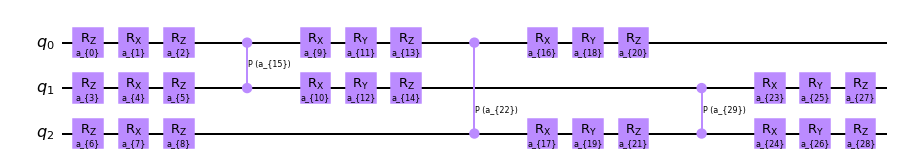

In [8]:
anz = Ansatz(3, 'cp', fill_layers(connected_layer(3),3))
anz.circuit().draw(output='mpl')

Regularization function.

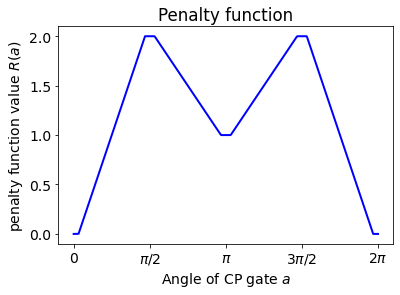

In [9]:
regularization_options = RegularizationOptions(plato_0=0.1, plato_1=0.1, plato_2=0.1)
regularization_func = make_regularization_function(regularization_options)
a_sweep = jnp.linspace(0, 2*jnp.pi, 500)

plt.plot(a_sweep, vmap(regularization_func)(a_sweep), 'blue', linewidth=2)
plt.xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi], ['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.title('Penalty function')
plt.ylabel('penalty function value $R(a)$')
plt.xlabel('Angle of CP gate $a$')
plt.savefig('figures/penalty', dpi=1000, bbox_inches='tight')        

# Synthesis of Toffoli gates

## 3q Toffoli

### Connected

Optimal hyperparameters: k=7, r=0.0013153787719205608
Optimal decompositions (out of 100): 28


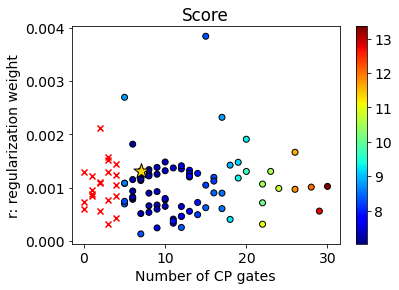

In [10]:
results = Results.load('results/toff3_conn_xyz')
k_best, r_best = results.best_hyperparameters()[0]
optimal_decompositions = [d for d in results.decompositions if d.cz_count==6]
print(f'Optimal hyperparameters: k={k_best}, r={r_best}')
print(f'Optimal decompositions (out of 100): {len(optimal_decompositions)-1}')
results.plot_trials()
plt.savefig('figures/toff3_trials_conn', dpi=1000, bbox_inches='tight')        

Best circuits in each nomination. The circuit with the best T depth is simultaneously the winner in all other nominations.

Total number of Clifford+T decompositoins (out of 100): 20
best CZ count: < toff3_conn_xyz| Clifford+T | loss: 0.0  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 5 >
best CZ depth: < toff3_conn_xyz| Clifford+T | loss: 0.0  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 5 >
best T count: < toff3_conn_xyz| Clifford+T | loss: 0.0  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 5 >
best T depth: < toff3_conn_xyz| Clifford+T | loss: 0.0  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 4 >

Best overall decomposition:


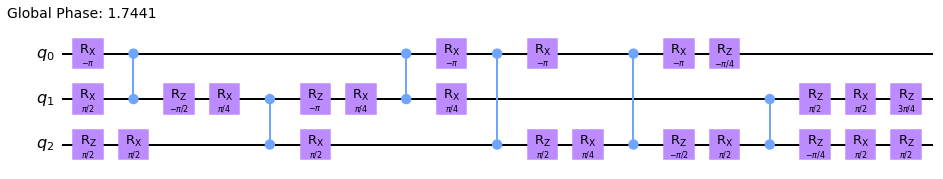

In [11]:
clifford_T_decompositions = [d for d in results.decompositions if d.t_count is not None]

best_cz_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_count)
best_cz_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_depth)
best_t_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_count)
best_t_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_depth)

print(f'Total number of Clifford+T decompositoins (out of 100): {len(clifford_T_decompositions)}')

print('best CZ count:', best_cz_count_decomposition)
print('best CZ depth:', best_cz_depth_decomposition)
print('best T count:', best_t_count_decomposition)
print('best T depth:', best_t_depth_decomposition)

print('\nBest overall decomposition:')
best_decomposition = best_t_depth_decomposition
qc = best_decomposition.circuit
qc.draw(output='mpl')

Decomposition at Fig.10, top panel.

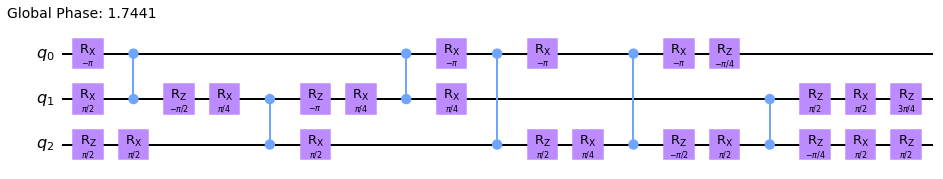

In [12]:
best_decomposition.circuit.draw(output='mpl')

To reproduce adaptive synthesis or simply inspect the corresponding options one can run the following.

In [13]:
first_decomposition = results.decompositions[0]

adaptive_options = first_decomposition._adaptive_options

decomposer = first_decomposition._decomposer
decomposer.label = 'toff3_conn_reproduced' # If we do not change the label new results will be merged with existing.

adaptive_options
### Uncomment the line below to reproduce results.
# reproduced_results = decomposer.adaptive(adaptive_options)

AdaptiveOptions(num_samples=200, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xyz', min_num_cp_gates=0, max_num_cp_gates=30, r_mean=0.00055, r_variance=0.5, max_evals=100, target_num_cz_gates=0, stop_if_target_reached=False, keep_logs=False)

To reproduce the static synthesis:

In [14]:
last_decomposition = results.decompositions[-1]
static_options = last_decomposition._static_options

static_options
### Uncomment the line below to reproduce results.
# reproduced_results = decomposer.static(static_options)

StaticOptions(num_samples=100, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xyz', num_cp_gates=7, r=0.00131, accepted_num_cz_gates=100)

Results for all other decompositions reported in this notebook can be reproduced in the same way.

### Chain

Best hyperparameters: k=14, r=0.000882908121237346
Optimal decompositions (out of 100): 19


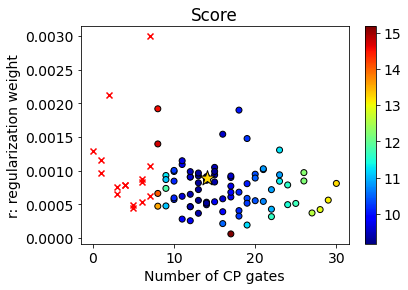

In [15]:
results = Results.load('results/toff3_chain_xyz')
k_best, r_best = results.best_hyperparameters()[0]
optimal_decompositions = [d for d in results.decompositions if d.cz_count==8]
print(f'Best hyperparameters: k={k_best}, r={r_best}')
print(f'Optimal decompositions (out of 100): {len(optimal_decompositions)-1}')
results.plot_trials()
plt.savefig('figures/toff3_trials_chain', dpi=1000, bbox_inches='tight')        

Again, the best overall decomposition turns out to be the one with the smallest T depth.

Total number of Clifford+T decompositoins (out of 100): 9
best CZ count: < toff3_chain_xyz| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
best CZ depth: < toff3_chain_xyz| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
best T count: < toff3_chain_xyz| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
best T depth: < toff3_chain_xyz| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 3 >

Best overall decomposition:


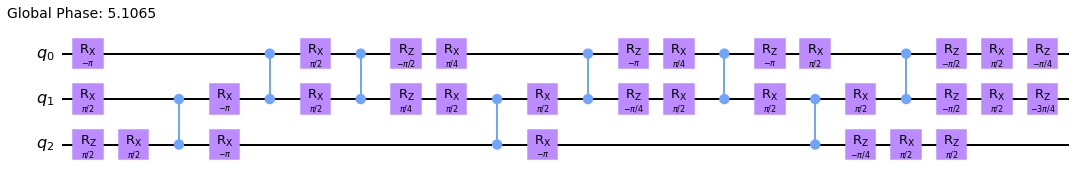

In [16]:
clifford_T_decompositions = [d for d in results.decompositions if d.t_count is not None]

best_cz_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_count)
best_cz_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_depth)
best_t_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_count)
best_t_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_depth)

print(f'Total number of Clifford+T decompositoins (out of 100): {len(clifford_T_decompositions)}')

print('best CZ count:', best_cz_count_decomposition)
print('best CZ depth:', best_cz_depth_decomposition)
print('best T count:', best_t_count_decomposition)
print('best T depth:', best_t_depth_decomposition)

print('\nBest overall decomposition:')
best_decomposition = best_t_depth_decomposition
qc = best_decomposition.circuit
qc.draw(output='mpl')

## 4q Toffoli

Throughout this section we load precomputed results of synthesis on various 4q Topologies, plot the corresponding trials and best decompositions. Additionally, for connected and star topology we compute success ratios of CZ templates reported in Table III of the paper.

### Connected

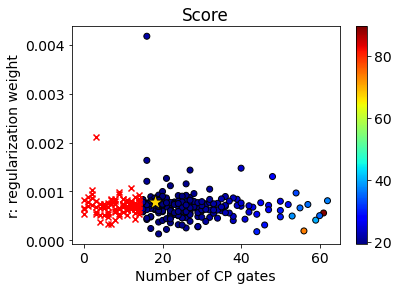

In [17]:
results = Results.load('results/toff4_conn_xyz')
results.plot_trials()

Best decomposition found during the adaptive synthesis.

< toff4_conn_xyz| Rational | loss: 2.384185791015625e-07  | CZ count: 14 | CZ depth: 11  >


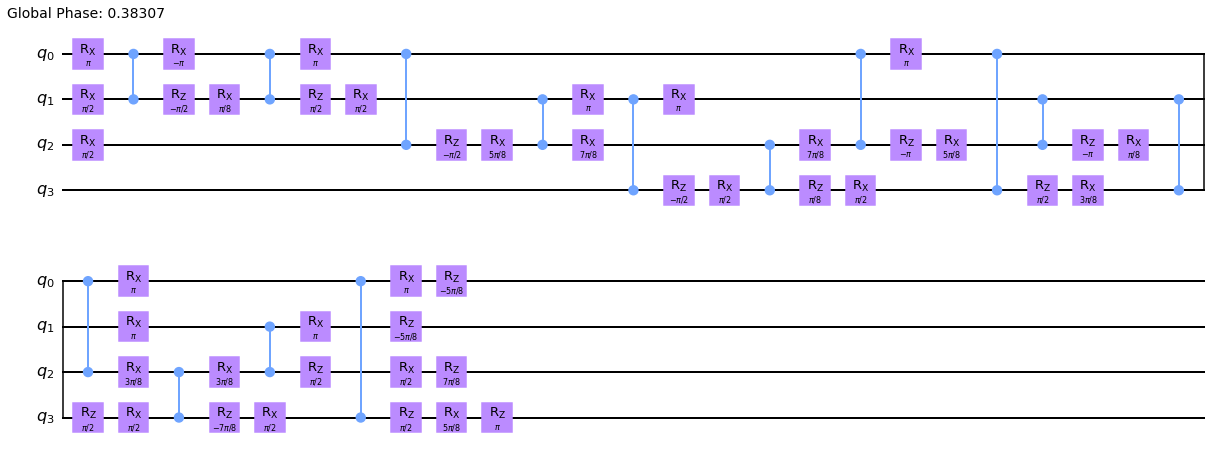

In [18]:
d = results.decompositions[-1]
print(d)
d.circuit.draw(output='mpl')

Success Ratios for 'XZ' and 'XYZ' templates to learn the decomposition shown above starting from a fixed correct architecture and random initialization of angles. 

In [19]:
# placements = {'free': get_placements(d.circuit)}
# anz = Ansatz(4, 'cz', placements, rotation_gates='xz')

# res = anz.learn(
#     u_toff4, 
#     method='adam',
#     learning_rate=0.1,
#     num_iterations=5000,
#     num_repeats=500)

# success_record = [jnp.min(r['loss'])<1e-4 for r in res]
# sr = sum(success_record)/len(success_record)
# print(f"Success Ratio 'XZ' is {sr}")

In [20]:
# placements = {'free': get_placements(d.circuit)}
# anz = Ansatz(4, 'cz', placements, rotation_gates='xyz')

# res = anz.learn(
#     u_toff4, 
#     method='adam',
#     learning_rate=0.1,
#     num_iterations=5000,
#     num_repeats=500)

# success_record = [jnp.min(r['loss'])<1e-4 for r in res]
# sr = sum(success_record)/len(success_record)
# print(f"Success Ratio 'XYZ' is {sr}")

### Kite

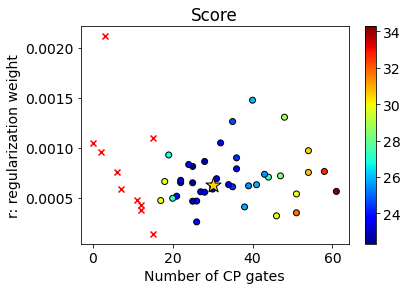

In [21]:
results = Results.load('results/toff4_kite_xyz')
results.plot_trials()

Best decomposition found during the adaptive synthesis.

< toff4_kite_xyz| Rational | loss: 1.1920928955078125e-07  | CZ count: 14 | CZ depth: 13  >


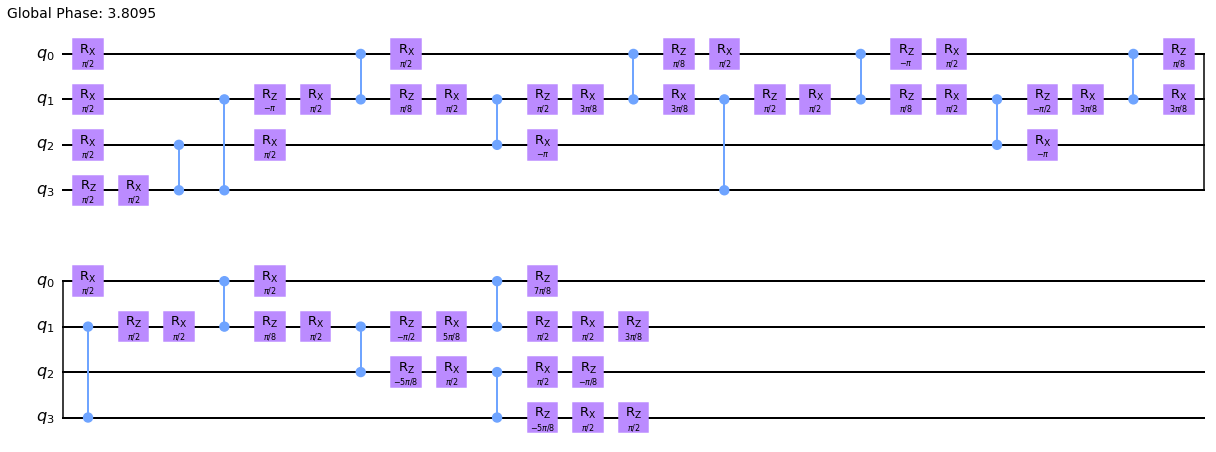

In [22]:
d = results.decompositions[-1]
print(d)
d.circuit.draw(output='mpl')

### Square

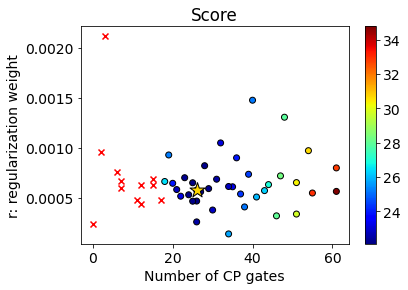

In [23]:
results = Results.load('results/toff4_square_xyz')
results.plot_trials()

Best decomposition found during the adaptive synthesis.

< toff4_square_xyz| Rational | loss: 1.1920928955078125e-07  | CZ count: 16 | CZ depth: 15  >


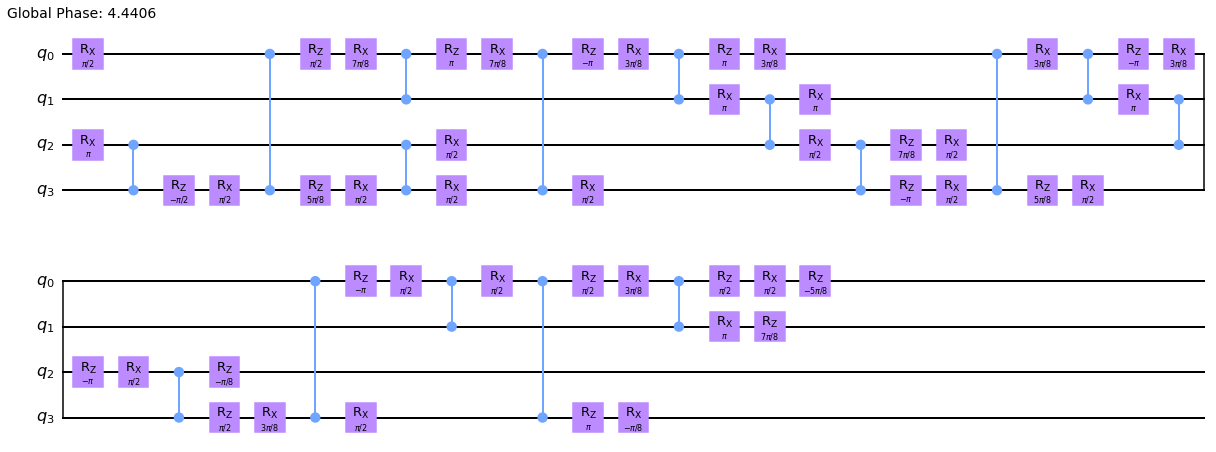

In [24]:
d = results.decompositions[-1]
# d.refine()
# results.save()
print(d)
d.circuit.draw(output='mpl')

### Star

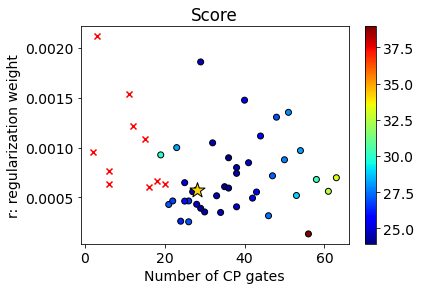

In [25]:
results = Results.load('results/toff4_star_xyz')
results.plot_trials()

In this case our automated procedure failed to make all angles rational.

In [26]:
d = results.decompositions[-1]
d.refine()
print(d)

< toff4_star_xyz| Approximate | loss: 0.0  | CZ count: 16 | CZ depth: 16  >


Here is a quick and dirty workaround manually rounding off gate angles.

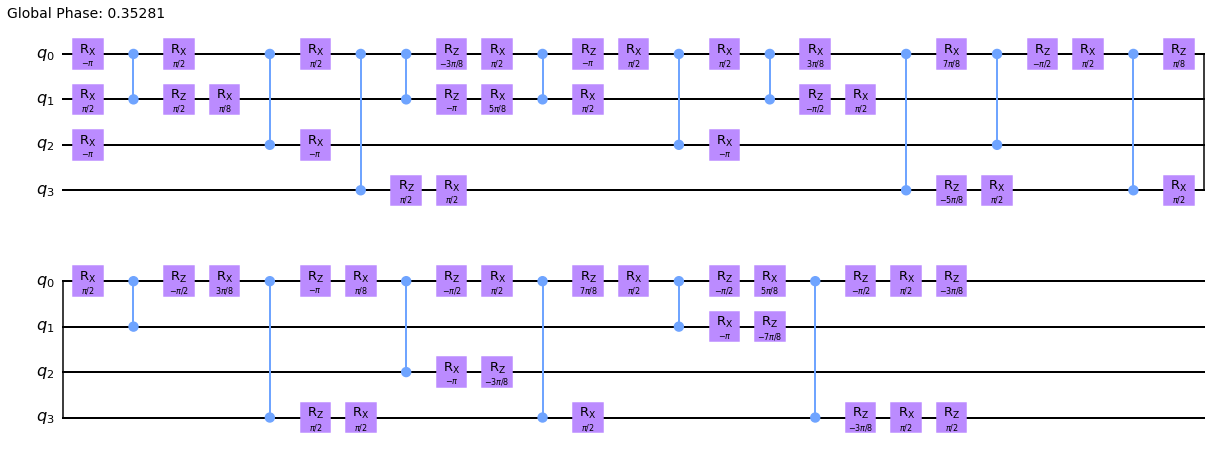

In [27]:
qx = d.circuit.copy()

new_data = []
for gate, qargs, cargs in qx.data:
    if gate.name in ['rx', 'ry', 'rz']:
        new_gate = gate
        angle = bracket_angle(gate.params[0])
        new_gate.params = [jnp.pi * Fraction.from_float(angle/jnp.pi).limit_denominator(8)]
    else:
        new_gate = gate
    new_data.append((gate, qargs, cargs))

qx.data = new_data
qx = remove_zero_rgates(qx)
qx.draw(output='mpl')

Let's check that the resulting circuit indeed compiles the 4q Toffoli within machine precision.

In [28]:
cost_HST(Operator(qx.reverse_bits()).data, u_toff4)

DeviceArray(0., dtype=float32)

Here is the split that was used to fit the circuit into the paper width.

In [29]:
qx_0 = qx.copy()
qx_1 = qx.copy()

split = 36

qx_0.data = qx.data[:split]
qx_1.data = qx.data[split:]

print(cost_HST(Operator(qx).data, Operator(qx_0.compose(qx_1)).data))

1.1920929e-07


"Upper" circuit at Fig.11 

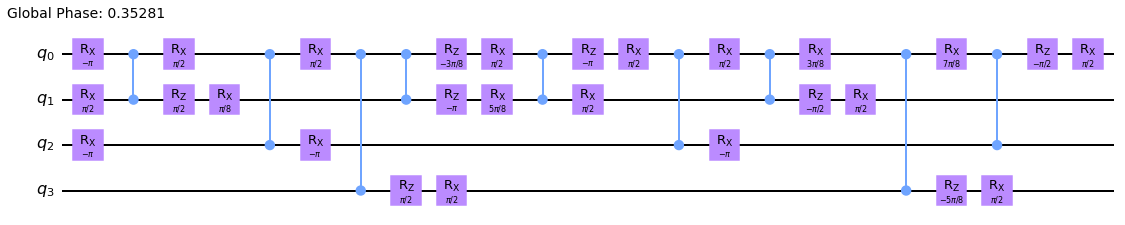

In [30]:
qx_0.draw(output='mpl')

"Lower" circuit at Fig.11

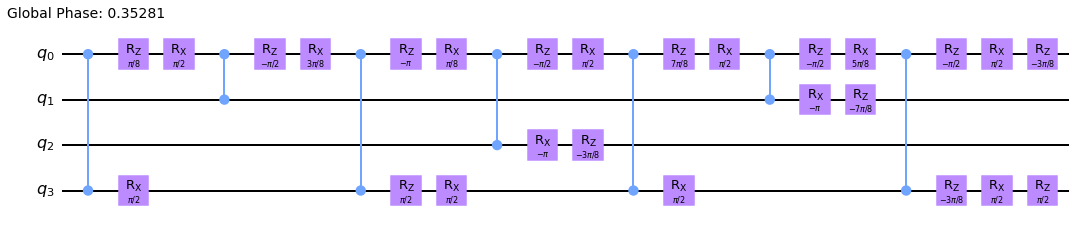

In [31]:
qx_1.draw(output='mpl')

Success Ratios for 'XZ' and 'XYZ' templates to learn the decomposition shown above starting from a fixed correct architecture and random initialization of angles. 

In [32]:
# placements = {'free': get_placements(qx)}

# anz = Ansatz(4, 'cz', placements, rotation_gates='xyz')

# res = anz.learn(
#     u_toff4, 
#     method='adam',
#     learning_rate=0.1,
#     num_iterations=5000,
#     num_repeats=500)

# success_record = [jnp.min(r['loss'])<1e-4 for r in res]
# sr = sum(success_record)/len(success_record)
# print(f"Success Ratio 'xyz' is {sr}")

In [33]:
# placements = {'free': get_placements(qx)}

# anz = Ansatz(4, 'cz', placements, rotation_gates='xz')

# res = anz.learn(
#     u_toff4, 
#     method='adam',
#     learning_rate=0.1,
#     num_iterations=5000,
#     num_repeats=500)

# success_record = [jnp.min(r['loss'])<1e-4 for r in res]
# sr = sum(success_record)/len(success_record)
# print(f"Success Ratio 'xz' is {sr}")

### Chain

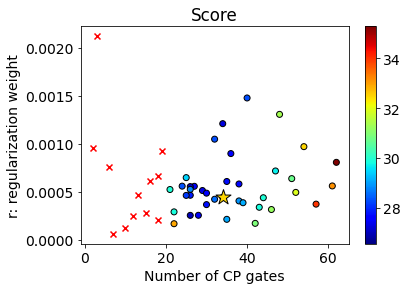

In [34]:
results = Results.load('results/toff4_chain_xyz')
results.plot_trials()

Best decomposition found during the adaptive synthesis.

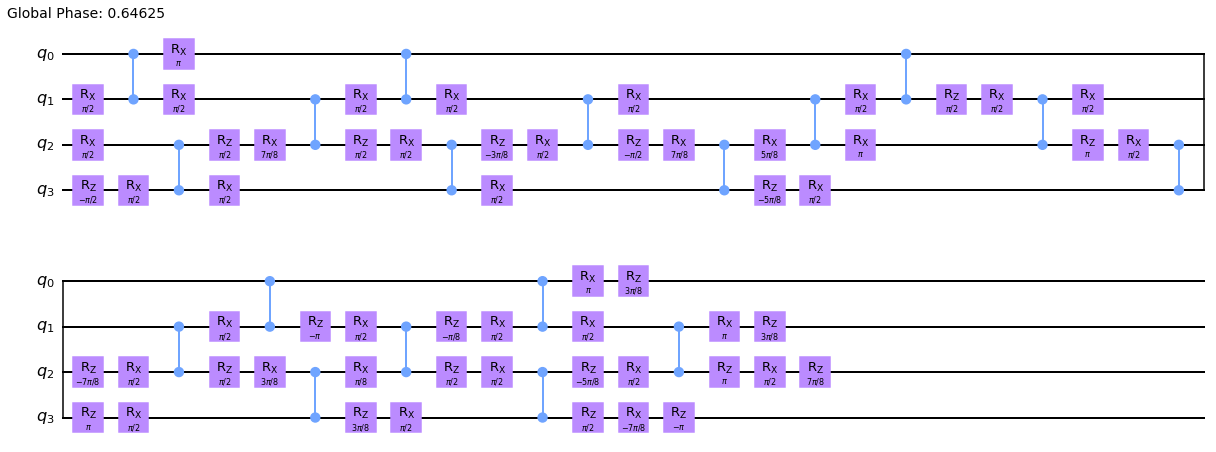

In [35]:
d = results.decompositions[-1]
d.circuit.draw(output='mpl')

## Toffoli 5

### $C^3\sqrt{X}$ and 4q relative pahse Toffoli gates on the chain topology.

To compile the 5q Toffoli gate on the chain topology we used two auxiliary 4q circuits: relative phase 4q Toffoli gate and triply controlled $\sqrt{X}$ gate, both on the 4q chain topologies. Each of the auxiliary circuits was compiled by CPFlow. Here we first load these results.

$C^{3}\sqrt{X}$ gate on the chain topology:

< toff4_sqrt_chain_xyz| Rational | loss: 0.0  | CZ count: 18 | CZ depth: 13  >


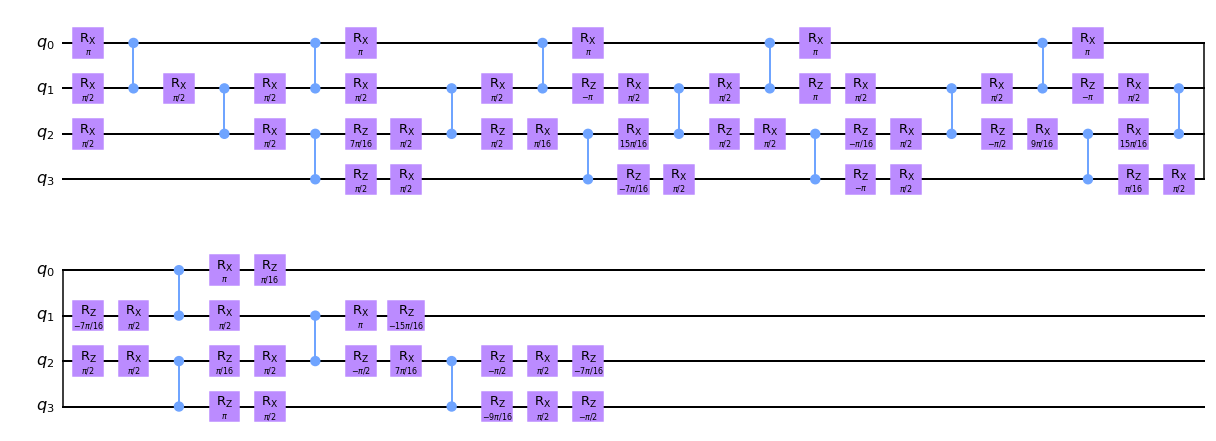

In [36]:
results = Results.load('results/toff4_sqrt_chain_xyz')
d = results.decompositions[-1]
print(d)

qc_toff4_sqrt = d.circuit
qc_toff4_sqrt.global_phase=0

g_toff4_sqrt = qc_toff4_sqrt.to_instruction(label='T4_sqrt')
g_toff4_sqrt.name = 'T4_sqrt'

qc_toff4_sqrt.draw(output='mpl')

Relative phase 4q Toffoli gate on the chain topology:

< toff4_relative_chain| Clifford+T | loss: 3.3868501336797863e-09  | CZ count: 11 | CZ depth: 9  | T count: 12 | T depth: 8 >


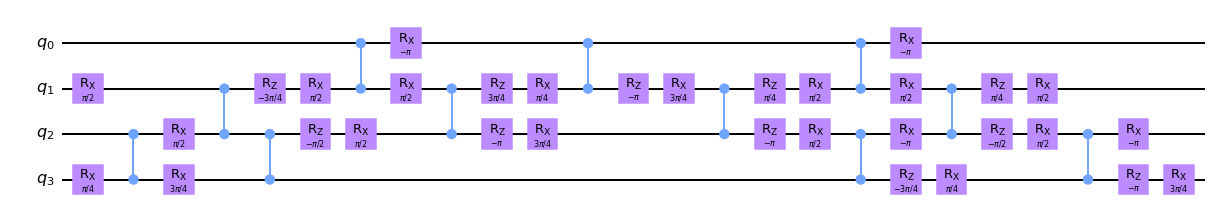

In [37]:
results = Results.load('results/toff4_relative_chain')
d = results.decompositions[2]
print(d)

qc_toff4_relative = d.circuit
qc_toff4_relative.global_phase=0

g_toff4_relative = qc_toff4_relative.to_instruction(label='RT4')
g_toff4_relative.name = 'RT4'

# print(qc_toff4_relative.draw(output='latex_source'))
qc_toff4_relative.draw(output='mpl')

### Assembling 4q gates into the 5q Toffoli

Here is a possible decompositionso of the 5q Toffoli gate into $\le$4q gates that gives the optimal CZ counts on the fully connected topology.

0.0
True


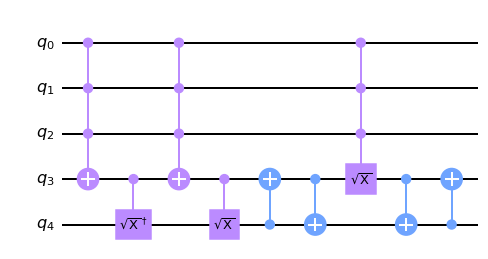

In [38]:
qc = QuantumCircuit(5)

qc.mct([0, 1, 2], 3)
qc.append(SXGate().control(1).inverse(), [3, 4])

qc.mct([0, 1, 2], 3)

qc.append(SXGate().control(1), [3, 4])

qc.cx(4,3)
qc.cx(3,4)
qc.append(SXGate().control(3), [0, 1, 2, 3])
qc.cx(3,4)
qc.cx(4,3)

print(cost_HST(Operator(qc.reverse_bits()).data, u_toff5))
print(jnp.allclose(Operator(qc.reverse_bits()).data, u_toff5))
qc.draw(output='mpl')

Here is the adaptation of the above decomposition to the chain topology with synthesized relative Toffoli 4 gate and square root of the 4q Toffoli gates.

0.0
True


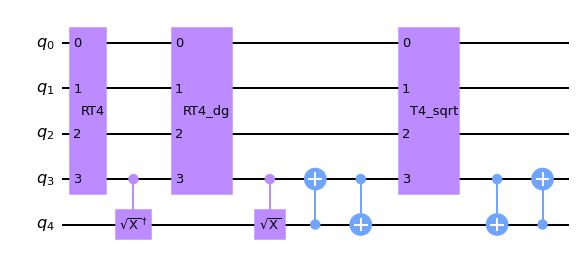

In [39]:
qc = QuantumCircuit(5)

qc.append(g_toff4_relative, [0, 1, 2, 3])
qc.append(SXGate().control(1).inverse(), [3, 4])
qc.append(g_toff4_relative.inverse(), [0, 1, 2, 3])

qc.append(SXGate().control(1), [3, 4])

qc.cx(4,3)
qc.cx(3,4)
qc.append(g_toff4_sqrt, [0, 1, 2, 3])
qc.cx(3,4)
qc.cx(4,3)

print(cost_HST(Operator(qc.reverse_bits()).data, u_toff5))
u = Operator(qc.reverse_bits()).data
u = u/u[0,0] # Changes the global phase

print(jnp.allclose(u, u_toff5))
qc.draw(output='mpl')

### Circuit diagram for $C^{3}\sqrt{X}$ shown in the paper (Fig.15)

In [40]:
qc0 = qc_toff4_sqrt.copy()
qc1 = qc_toff4_sqrt.copy()
qc2 = qc_toff4_sqrt.copy()

split01 = 24
split12 = 52

qc0.data = qc_toff4_sqrt.data[:split01]
qc1.data = qc_toff4_sqrt.data[split01:split12]
qc2.data = qc_toff4_sqrt.data[split12:]

jnp.allclose(Operator(qc0.compose(qc1).compose(qc2)).data, Operator(qc_toff4_sqrt).data)

DeviceArray(True, dtype=bool)

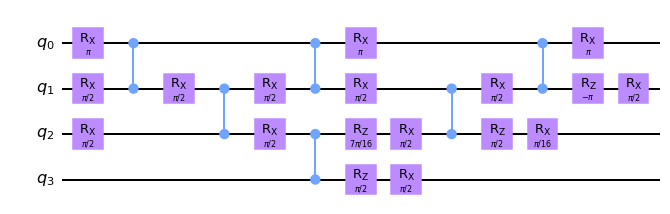

In [41]:
# print(qc0.draw(output='latex_source'))
qc0.draw(output='mpl')

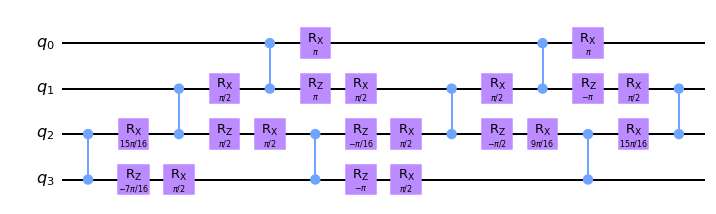

In [42]:
# print(qc1.draw(output='latex_source'))
qc1.draw(output='mpl')

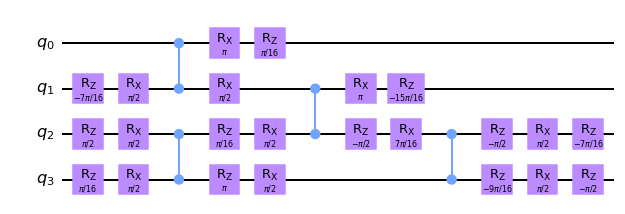

In [43]:
# print(qc2.draw(output='latex_source'))
qc2.draw(output='mpl')

# Further benchmarks

We first define a simple dataclass that holds results of syntesis by various packages reported in the paper. Results for third party packages copied from the [SQUANDER paper](https://arxiv.org/abs/2203.04426). CPFlow results are taken from local files and double-checked at loading.

In [44]:
@dataclass
class benchmark_circuit:
    name: str
    cpflow: int    
    squander: int
    qfast: int
    qsearch: int
    
    num_trials: int = -1
    label: str = ''
        
    def original_circuit(self):
        return QuantumCircuit.from_qasm_file(f'benchmark_circuits/Table {self.label[-1]}/{self.name}.qasm')
    
    def check_cpflow(self):
        """Before assigning a CPFlow result to a benchamrk circuit we verify that it does compile the target unitary
        and also that it complies with the qubit topology if applicable."""
        
        # '4gt5_76' is the only circuit that was compiled on both connected and chain topologies and requires a separate treatement.
        if self.name=='4gt5_76':
            if self.label=='t1':
                results = Results.load('results/benchmarks/res_4gt5_76_conn')
            elif self.label=='t3':
                results = Results.load('results/benchmarks/res_4gt5_76_chain')
        else:
            results = Results.load(f'results/benchmarks/res_{self.name}')
        
        decompositions = results.decompositions
        best_decomposition = min(decompositions, key = lambda d: d.cz_count)
        
        qc = best_decomposition.circuit
        # Check equivalence to the original circuit
        assert cost_HST(Operator(qc).data, Operator(self.original_circuit()).data) < 1e-6
        # Check topological restrictions for circuits from Table 3.
        if self.label=='t3':  # Third table contains circuits that are compiled onto the chain topology.
            placements = get_placements(qc)
            breaks_topology = False in [p in chain_layer(5) for p in placements]
            assert not breaks_topology, 'Breaks topology'
        self.cpflow = best_decomposition.cz_count
        self.num_trials = len(results.trials.results)

        
# -1 stands for undetirmined results, gate counts for QSearch and SQUANDER are inserted manually, CPFlow results will be added later.
benchmark_circuits = [
    benchmark_circuit('4gt5_76', -1, 24, 29, -1, label='t1'),
    benchmark_circuit('one-two-three-v2_100', -1, 37, 52, 43, label='t1'),
    benchmark_circuit('alu-v3_34', -1, 25, 37, 27, label='t1'),
    benchmark_circuit('alu-v4_36', -1, 40, 49, -1, label='t1'),
    benchmark_circuit('4gt13_92', -1, 24, 46, -1, label='t1'),

    benchmark_circuit('4gt13_91', -1, 26, 55, 35, label='t3'),
    benchmark_circuit('4gt5_76', -1, 26, 51, 27, label='t3'),
    benchmark_circuit('alu-v0_26', -1, 32, 56, -1, label='t3'),
    benchmark_circuit('alu-v3_35', -1, 26, 62, 34, label='t3'),
    benchmark_circuit('4mod5-v1_24', -1, 31, 81, 44, label='t3'),

    benchmark_circuit('4gt10-v1_81', -1, 39, -1, -1, label='t4'),
    benchmark_circuit('one-two-three-v1_99', -1, 45, -1, -1, label='t4'),
    benchmark_circuit('one-two-three-v0_98', -1, 61, -1, -1, label='t4'),
    benchmark_circuit('aj-e11_165', -1, 36, -1, -1, label='t4'),
    benchmark_circuit('alu-v2_32', -1, 41, -1, -1, label='t4')]

Yet `benchmark_circuits` are initialized without decompositions found by CPFlow. We now fill in those, verify against the original circuits (and connectivity) and report results in a table.

In [45]:
for bc in benchmark_circuits:
    try:
        bc.check_cpflow()
    except (AssertionError, ValueError) as e:
        print(bc.name)
        print(e)

table_data = []
for bc in benchmark_circuits:
    table_data.append(vars(bc))
    
DataFrame(table_data, range(len(table_data)))

,name,cpflow,squander,qfast,qsearch,num_trials,label
0,4gt5_76,21,24,29,-1,100,t1
1,one-two-three-v2_100,28,37,52,43,100,t1
2,alu-v3_34,14,25,37,27,100,t1
3,alu-v4_36,30,40,49,-1,100,t1
4,4gt13_92,17,24,46,-1,100,t1
5,4gt13_91,25,26,55,35,100,t3
6,4gt5_76,22,26,51,27,100,t3
7,alu-v0_26,28,32,56,-1,100,t3
8,alu-v3_35,24,26,62,34,100,t3
9,4mod5-v1_24,29,31,81,44,100,t3


# Appendix A: circuit refinement

Here we illustrate the circuit refinment procedure. First let us generate a decomposition of the 3q Toffoli gate.

In [46]:
decomposer = Synthesize(connected_layer(3), target_unitary=u_toff3, label='refine_test')
options = StaticOptions(num_cp_gates=7, num_samples=1, accepted_num_cz_gates=6, rotation_gates='xz')
results = decomposer.static(options)


Starting decomposition routine with the following options:

 StaticOptions(num_samples=1, method='adam', learning_rate=0.1, num_gd_iterations=2000, cp_distribution='uniform', entry_loss=0.001, target_loss=1e-06, threshold_cp=0.2, learning_rate_at_verification=0.01, num_gd_iterations_at_verification=5000, random_seed=0, rotation_gates='xz', num_cp_gates=7, r=0.00055, accepted_num_cz_gates=6)

Computing raw results...

Selecting prospective results...

Found 1. Verifying...


  0%|          | 0/1 [00:00<?, ?it/s]


1 successful. cz counts are:
[6]


Here is what the raw decomposition looks like.

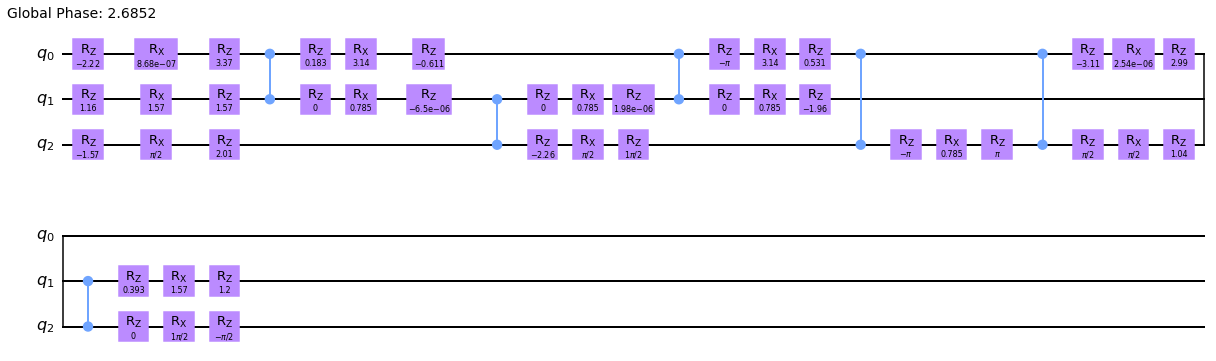

In [47]:
d = results.decompositions[-1]
qc = d.circuit
qc.draw(output='mpl')

Now we check if there are pairwise "cancellations of angles" and take advantage of those when found.

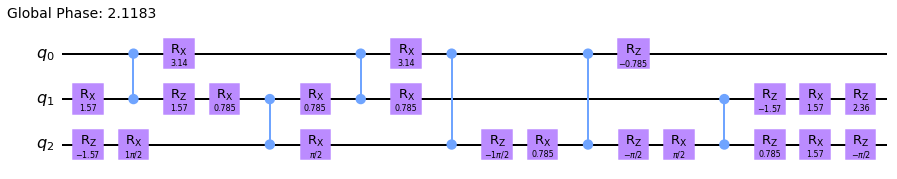

In [48]:
qc_reduced = reduce_angles(qc, d.unitary_loss_func)
qc_reduced = remove_zero_rgates(qc_reduced)

qc_reduced.draw(output='mpl')

Now we round angles to rational multiples of $\pi$.

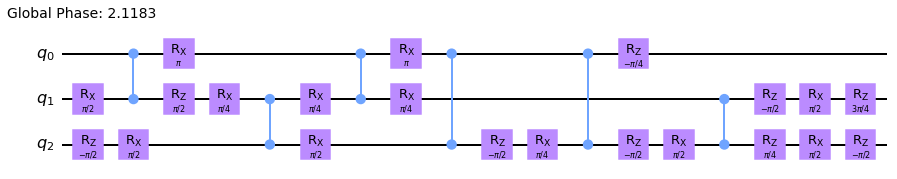

In [49]:
qc_rationalized = rationalize_all_rgates(qc_reduced)
qc_rationalized.draw(output='mpl')